參考資料：
1. AE in keras: https://blog.keras.io/building-autoencoders-in-keras.html
- Autoencoder 自编码:https://morvanzhou.github.io/tutorials/machine-learning/keras/2-6-autoencoder/
- PSNR、SSIM:
 - http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_psnr
 - http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.compare_ssim
- 28 Jupyter Notebook tips, tricks, and shortcuts:
 - https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/

In [126]:
# 時間計算
import time 
# 數值運算
import numpy as np
# 圖片輸出用
from matplotlib import pyplot as plt
from cv2 import imwrite 
# 結果運算用
from skimage.measure import compare_psnr, compare_ssim 

In [127]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
# from keras.models import load_model

In [128]:
_startTime = time.time()

##### 函數 - 測試用

In [129]:
def CheckType(intVar):
    print("max:",   intVar.max())
    print("min:",   intVar.min())
    print("shape:", intVar.shape)
    print("type:",  intVar.dtype)
    return

##### 函數 - 輸出用

In [130]:
def ResultImgShow(inputImg, modelName, strImgLabel = "TMP"):
    # 輸出參數設置
    img_amount = inputImg.shape[0]
    cols_output = 50
    rows_output = img_amount // cols_output
#     # 改變大小用，但這裡有確切大小所以不必處理
#     if rows_output < 3:
#         cols_output = 10
#         rows_output = img_amount // cols_output
#         if rows_output < 3:
#             cols_output = 5
#             rows_output = img_amount // cols_output
    if rows_output > cols_output:
        rows_output = cols_output
    # 輸出設置 - 水平堆疊再垂直堆疊
    ## v - 初始
    img_h = inputImg[0]
    for i in range(1, cols_output):
        img_tmp = inputImg[i]
        img_h = np.hstack((img_h, img_tmp))
    img_v = img_h.copy()
    ## v - Loop
    for j in range(1, rows_output):
        ## h - 初始
        img_h = inputImg[j * cols_output]
        ## h - Loop
        for i in range(1, cols_output):
            img_tmp = inputImg[j * cols_output + i]
            img_h = np.hstack((img_h, img_tmp))
        img_v = np.vstack((img_v, img_h))
    # 顯示 與 存取
    imwrite(modelName.split(".")[0] +"_"+ strImgLabel+ ".png", img_v)
    plt.imshow(img_v, cmap = "gray")
#     plt.savefig(model_name.split(".")[0] +"_"+ strImgLabel+ ".png")
    plt.show()
    plt.close()
    return

###### 函數 - 計算誤差

In [131]:
def PSNR_ALL(testData, truthData, strImgLabel = "TMP", boolTest = False):
    """ """
#     dataAmount = 1 if testData.shape < 3 else testData.shape[0]
#     if testData.shape < 3:
#         dataAmount = 1
#     else:
    dataAmount = testData.shape[0]
    psnrSum_test = 0
    for i in range(dataAmount):
        groundTruth   = truthData[i, :,:]
        predictResult = testData[i, :,:]
        psnrTmp = float(compare_psnr(groundTruth, predictResult))
        psnrSum_test += psnrTmp
    psnrSum_test /= dataAmount
    print(strImgLabel, "PSNR:", psnrSum_test)
    return psnrSum_test

In [132]:
def SSIM_ALL(testData, truthData, strImgLabel = "TMP", boolTest = False):
    dataAmount = testData.shape[0]
    ssimSum_test = 0
    for i in range(dataAmount):
        groundTruth   = truthData[i, :,:]
        predictResult = testData[i, :,:]
        ssimTmp = float(compare_ssim(groundTruth, predictResult))
        ssimSum_test += ssimTmp
    ssimSum_test /= dataAmount
    print(strImgLabel, "SSIM:", ssimSum_test)
    return ssimSum_test

###### 函數 - 預處理與後處理

In [133]:
def DataPreProcess(inputData, img_rows = 28, img_cols = 28):
    outputData = inputData.reshape(inputData.shape[0], img_rows * img_cols)
    outputData = outputData.astype('float32') /255 -0.5
    outputData *= 2
    return outputData

In [134]:
def DataRecovery(inputData, img_rows = 28, img_cols = 28):
    outputData = ((inputData /2)+0.5) * 255
    outputData = outputData.reshape((outputData.shape[0], img_rows, img_cols))
    outputData = outputData.astype('uint8')
    return outputData

# 主程式

In [135]:
class AE:
    def __init__(self, img_rows = 28, img_cols = 28, channels = 1):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.shape = (self.img_rows, self.img_cols, self.channels)
                
        self.E = self.__encoder_complex()
#         self.G.compile(loss='binary_crossentropy', optimizer=self.optimizer)
        self.D = self.__dencoder_complex()
#         self.D.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        
        self.stacked_AE = self.__stacked_E_D()
        self.stacked_AE.compile(optimizer='adam', loss='mse')
        return
    
    def __encoder_complex(self):
        model = Sequential()
        model.add(Dense(1500, activation='relu', input_shape=(784,)))
        model.add(Dense(375, activation='relu')) 
        model.add(Dense(50)) 
#         model.summary()
        return model 
    
    def __dencoder_complex(self):
        model = Sequential()
        model.add(Dense(375, activation='relu')) 
        model.add(Dense(1500, activation='relu')) 
        model.add(Dense(784, activation='tanh')) 
#         model.summary()
        return model 
    
    def __stacked_E_D(self):
#         self.D.trainable = False
        
        model = Sequential()
        model.add(self.E)
        model.add(self.D)
        
        return model # model
    
    def Train(self, x_train_org, batch_size = 128, epochs = 500):
        history_complex = self.stacked_AE.fit(x_train_org, x_train_org, # 訓練資料、結果比對資料
                    batch_size=batch_size, 
                    epochs=epochs)
        return self.stacked_AE
    

#### 參數設置

In [136]:
outputFolder = "output121223_symmetry/" # 不再偵測存在與否

In [148]:
batch_size = 128 #大概 3.8 GB
# num_classes = 10
epochs = 500
# input image dimensions
img_rows, img_cols = 28, 28

##### 讀取訓練資料
- 利用完整沒雜訊的資料進行訓練 。
- 只取用圖像，不取標籤。

In [137]:
datasetFolder = "./"

In [138]:
dataSetName_org = "mnist.npz"
f = np.load(datasetFolder + dataSetName_org)
x_train_org, x_test_org = f['x_train'], f['x_test']
del f

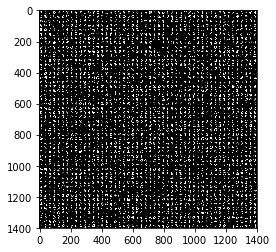

In [139]:
ResultImgShow(x_test_org, outputFolder + "CLEAR-IN", strImgLabel = "ORIGIN")

In [140]:
x_train_org = DataPreProcess(x_train_org)
print(x_train_org.shape[0], 'train samples', "in", x_train_org.shape)

60000 train samples in (60000, 784)


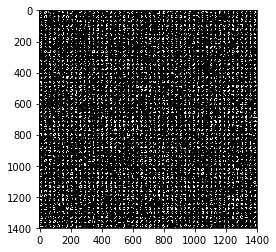

In [141]:
# 先將處理過的原資料，輸出
_x_train_org = DataRecovery(x_train_org)
ResultImgShow(_x_train_org, outputFolder + "PROCESSED", strImgLabel = "ORIGIN")
del _x_train_org

###### 讀取測試資料
- 由完整的資料集訓練，得到完整特性

In [142]:
dataSetName_noise = "mnist-pria-awgn_snr=10.npz"
f = np.load(datasetFolder + dataSetName_noise)
x_train_noise, x_test_noise = f['x_train'], f['x_test']
del f

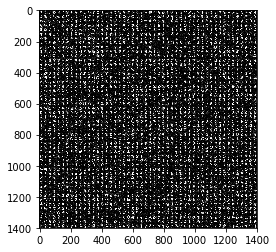

In [143]:
ResultImgShow(x_test_noise, outputFolder + "CLEAR-IN", strImgLabel = "BEFORE")

In [144]:
# 預處理
x_test_noise = DataPreProcess(x_test_noise)

## 模組架設 - 複雜版

In [145]:
ae = AE()

#### 模組 - 簡介

#### 模組 - 架設

#### 模組 - 訓練
用完整圖片訓練，完整圖片比對

In [146]:
autoencoder_complex = ae.Train(x_train_org = x_train_org, batch_size = batch_size, epochs = epochs)

Epoch 1/500
60000/60000 [==============================] - 12s 195us/step - loss: 0.0779
Epoch 2/500
60000/60000 [==============================] - 6s 98us/step - loss: 0.0306
Epoch 3/500
60000/60000 [==============================] - 6s 103us/step - loss: 0.0242
Epoch 4/500
60000/60000 [==============================] - 6s 101us/step - loss: 0.0211
Epoch 5/500
60000/60000 [==============================] - 6s 99us/step - loss: 0.0192
Epoch 6/500
60000/60000 [==============================] - 6s 98us/step - loss: 0.0179
Epoch 7/500
60000/60000 [==============================] - 6s 98us/step - loss: 0.0168
Epoch 8/500
60000/60000 [==============================] - 6s 98us/step - loss: 0.0160
Epoch 9/500
60000/60000 [==============================] - 6s 98us/step - loss: 0.0153
Epoch 10/500
60000/60000 [==============================] - 6s 98us/step - loss: 0.0148
Epoch 11/500
60000/60000 [==============================] - 6s 98us/step - loss: 0.0144
Epoch 12/500
60000/60000 [===========

60000/60000 [==============================] - 6s 97us/step - loss: 0.0087
Epoch 95/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0086
Epoch 96/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0087
Epoch 97/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0086
Epoch 98/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0086
Epoch 99/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0087
Epoch 100/500
60000/60000 [==============================] - 6s 98us/step - loss: 0.0085
Epoch 101/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0086
Epoch 102/500
60000/60000 [==============================] - 6s 98us/step - loss: 0.0086
Epoch 103/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0086
Epoch 104/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0086
Epoch 105/500
60000/60000 [=============

Epoch 186/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0077
Epoch 187/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0077
Epoch 188/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0077
Epoch 189/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0077
Epoch 190/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0077
Epoch 191/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0077
Epoch 192/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0077
Epoch 193/500
60000/60000 [==============================] - 6s 101us/step - loss: 0.0076
Epoch 194/500
60000/60000 [==============================] - 6s 108us/step - loss: 0.0077 0s - loss
Epoch 195/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0077
Epoch 196/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0077
Epoch 197

60000/60000 [==============================] - 6s 98us/step - loss: 0.0073
Epoch 278/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0073
Epoch 279/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0073
Epoch 280/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0073
Epoch 281/500
60000/60000 [==============================] - 6s 98us/step - loss: 0.0073
Epoch 282/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0073
Epoch 283/500
60000/60000 [==============================] - 6s 98us/step - loss: 0.0072
Epoch 284/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0073
Epoch 285/500
60000/60000 [==============================] - 6s 98us/step - loss: 0.0073
Epoch 286/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0073
Epoch 287/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0073
Epoch 288/500
60000/60000 [========

60000/60000 [==============================] - 6s 97us/step - loss: 0.0070
Epoch 369/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0070
Epoch 370/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0070
Epoch 371/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0070
Epoch 372/500
60000/60000 [==============================] - 6s 98us/step - loss: 0.0070
Epoch 373/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0070
Epoch 374/500
60000/60000 [==============================] - 6s 98us/step - loss: 0.0071: 0s -
Epoch 375/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0070
Epoch 376/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0070
Epoch 377/500
60000/60000 [==============================] - 6s 98us/step - loss: 0.0071
Epoch 378/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0070
Epoch 379/500
60000/60000 [==

60000/60000 [==============================] - 6s 97us/step - loss: 0.0069
Epoch 460/500
60000/60000 [==============================] - 6s 98us/step - loss: 0.0069
Epoch 461/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0069
Epoch 462/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0069
Epoch 463/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0069
Epoch 464/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0069
Epoch 465/500
60000/60000 [==============================] - 6s 98us/step - loss: 0.0068
Epoch 466/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0069
Epoch 467/500
60000/60000 [==============================] - 6s 98us/step - loss: 0.0068
Epoch 468/500
60000/60000 [==============================] - 6s 98us/step - loss: 0.0069:
Epoch 469/500
60000/60000 [==============================] - 6s 97us/step - loss: 0.0068
Epoch 470/500
60000/60000 [=======

#### 模組 - 儲存

In [149]:
model_name_complex = outputFolder + "model_complex"+"_e"+str(epochs)+"_b" + str(batch_size) + \
                    "class.h5"
#                     "_" + "-".join([str(i) for i in time.localtime()[0:5]]) +\

In [150]:
autoencoder_complex.save(model_name_complex)

#### 模組 - 使用與輸出

In [151]:
decodeImg_test = autoencoder_complex.predict(x_test_noise)
decodeImg_test = DataRecovery(decodeImg_test)

In [152]:
# decodeImg_test = PredictFlow(x_test_noise, decodeImg_test, boolPredict = True)

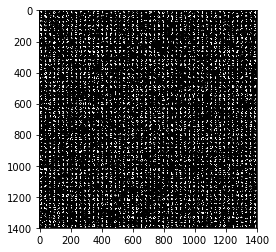

In [153]:
ResultImgShow(decodeImg_test, model_name_complex, strImgLabel = "AFTER");

### 計算結果 - 複雜版

In [154]:
PSNR_ALL(decodeImg_test, x_test_org, strImgLabel = "");
SSIM_ALL(decodeImg_test, x_test_org, strImgLabel = "");

 PSNR: 24.480315213847444
 SSIM: 0.9472577762207038


###### 清除

In [155]:
del autoencoder_complex
del decodeImg_test

###### 運行時間

In [156]:
_midTime = time.time()
print("It cost", _midTime - _startTime, "sec.")

It cost 3211.592284679413 sec.


## 模組架設 - 簡單版

#### 模組 - 簡介

#### 模組 - 架設

#### 模組 - 訓練
用完整圖片訓練，完整圖片比對

#### 模組 - 儲存

#### 模組 - 使用與輸出

### 計算結果 - 簡單版

###### 清除

###### 運行時間

In [157]:
print("Total cost", _endTime - _startTime, "sec.")

NameError: name '_endTime' is not defined